<a href="https://colab.research.google.com/github/AdrianUrbanski/ADM/blob/main/lista3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyts

     |████████████████████████████████| 2.5MB 5.9MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyts.classification import LearningShapelets
from pyts.utils import windowed_view

# Assignment 1

## a)

In [ ]:
def subsequence_dist(timeseries, shapelet):
    best_dist = np.infty

    for start in range(len(timeseries) - len(shapelet) + 1):
        dist = np.sum((timeseries[start:start + len(shapelet)] - shapelet)**2)
        if dist < best_dist:
            best_dist = dist

    return best_dist

In [ ]:
def info_gain(distances, labels, split):
    def entropy(labels):
        p_A = (labels == 0).sum() / len(labels)
        p_B = (labels == 1).sum() / len(labels)
        return -(p_A*np.log(p_A + np.exp(-100)) + p_B*np.log(p_B + np.exp(-100)))
        
    labels_1 = labels[np.where(distances < split)]
    fraction_1 = len(labels_1) / len(labels)
    labels_2 = labels[np.where(distances >= split)]
    fraction_2 = len(labels_2) / len(labels)

    if fraction_1 == 0 or fraction_2 == 0:
        return 0

    return entropy(labels) - (fraction_1*entropy(labels_1) + fraction_2*entropy(labels_2))

In [ ]:
def finding_shapelet_bf(dataset, labels, minlen, maxlen, n_best=1):
    def generate_candidates(dataset, minlen, maxlen):
        pool = set()
        for timeseries in dataset:
            for shapelet_length in range(minlen, maxlen+1):
                for start in range(len(timeseries) - shapelet_length + 1):
                    pool.add(tuple(timeseries[start:start+shapelet_length]))
        return pool

    def calculate_information_gain(distances, labels):
        best_gain = 0
        for split_point in np.unique(distances):
            gain = info_gain(distances, labels, split_point)
            if gain > best_gain:
                best_gain = gain

        return best_gain

    def check_candidate(dataset, shapelet, labels):
        distances = np.zeros(dataset.shape[0])
        for ts_idx in range(dataset.shape[0]):
            distances[ts_idx] = subsequence_dist(dataset[ts_idx], shapelet)

        return calculate_information_gain(distances, labels)

    candidates = generate_candidates(dataset, minlen, maxlen)

    gains = np.zeros(len(candidates))

    best_gain = 0
    best_shapelet = None

    for shapelet in candidates:
        gain = check_candidate(dataset, shapelet, labels)
        if gain > best_gain:
            best_gain = gain
            best_shapelet = shapelet

    return best_shapelet

## b)

In [ ]:
def generate_time_series(len=150, alpha=0.995):
    s = np.empty(len, dtype=float)
    s[0] = 0
    momentum = 0
    for pos in range(1, len):
        momentum = alpha*momentum + np.random.normal(0, 1)
        s[pos] = s[pos-1] + momentum
    s -= np.min(s)
    s /= np.max(s)
    return s

In [ ]:
def make_random_copy(s, len=100):
    base_len = s.shape[0]
    start = np.random.choice(base_len - len)
    return s[start: start+len]

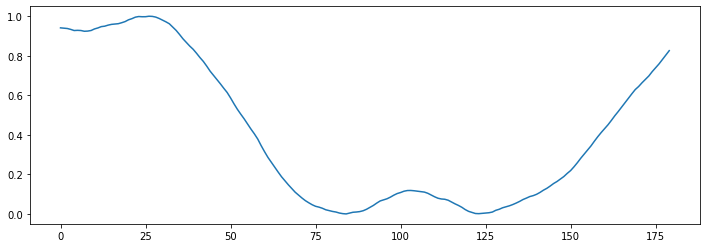

In [ ]:
plt.figure(figsize=(12,4))
base_time_series = generate_time_series(len=180)
plt.plot(base_time_series)

(0.0, 1.0)

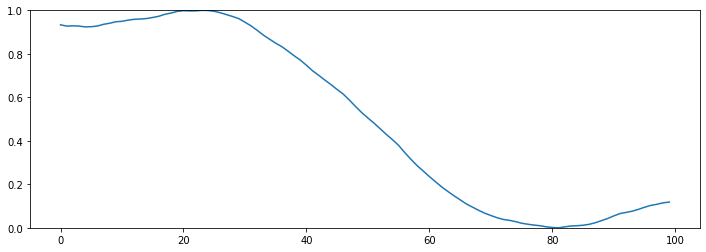

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(make_random_copy(base_time_series, len=100))
plt.ylim((0, 1))

In [ ]:
copies_count = 30
len_base = 90
len_copy = 50

ts1, ts2 = generate_time_series(len=len_base), generate_time_series(len=len_base)

dataset = np.empty((2*copies_count, len_copy))
labels = np.hstack((np.zeros(copies_count),
                    np.ones(copies_count)))

for copy_idx in range(copies_count):
    dataset[copy_idx] = make_random_copy(ts1, len=len_copy)
    dataset[copies_count + copy_idx] = make_random_copy(ts2, len=len_copy)

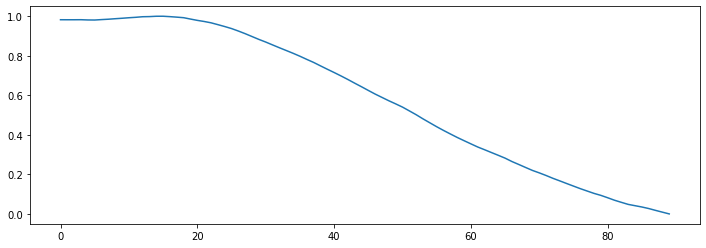

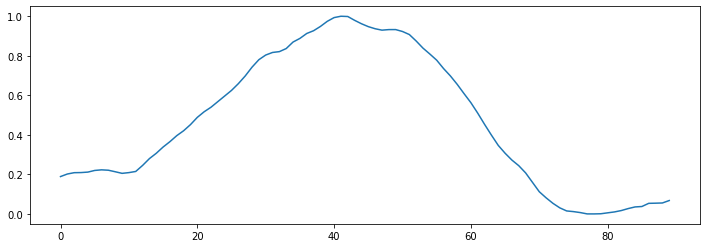

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(ts1)
plt.figure(figsize=(12,4))
plt.plot(ts2)

In [ ]:
shapelet = finding_shapelet_bf(dataset, labels, 10, 10)

0.0014155953940940863
0.0


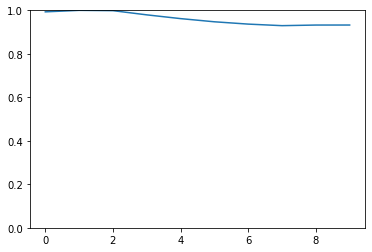

In [ ]:
plt.plot(shapelet)
plt.ylim((0, 1))

print(subsequence_dist(ts1, shapelet))
print(subsequence_dist(ts2, shapelet))

## c)

In [ ]:
def subsequence_dist(timeseries, shapelet):
    best_dist = np.infty

    for start in range(len(timeseries) - len(shapelet) + 1):
        dist = np.sum((timeseries[start:start + len(shapelet)] - shapelet)**2)
        if dist < best_dist:
            best_dist = dist

    return best_dist

In [ ]:
def info_gain(distances, labels, split):
    def entropy(labels):
        p_A = (labels == 0).sum() / len(labels)
        p_B = (labels == 1).sum() / len(labels)
        return -(p_A*np.log(p_A + np.exp(-100)) + p_B*np.log(p_B + np.exp(-100)))
        
    labels_1 = labels[np.where(distances < split)]
    fraction_1 = len(labels_1) / len(labels)
    labels_2 = labels[np.where(distances >= split)]
    fraction_2 = len(labels_2) / len(labels)

    if fraction_1 == 0 or fraction_2 == 0:
        return 0

    return entropy(labels) - (fraction_1*entropy(labels_1) + fraction_2*entropy(labels_2))

In [ ]:
def finding_shapelet_pruning(dataset, labels, minlen, maxlen, n_best=1):
    def generate_candidates(dataset, minlen, maxlen):
        pool = set()
        for timeseries in dataset:
            for shapelet_length in range(minlen, maxlen+1):
                for start in range(len(timeseries) - shapelet_length + 1):
                    pool.add(tuple(timeseries[start:start+shapelet_length]))
        return pool

    def calculate_information_gain(distances, labels):
        best_gain = 0
        for split_point in np.unique(distances):
            gain = info_gain(distances, labels, split_point)
            if gain > best_gain:
                best_gain = gain

        return best_gain

    def check_candidate(dataset, shapelet, labels, best_gain_so_far):
        def entropy_early_prune(best_gain_so_far, distances_A, distances_B, labels):
            if calculate_information_gain(distances_A, labels) > best_gain_so_far:
                return False
            if calculate_information_gain(distances_B, labels) > best_gain_so_far:
                return False
            return True

        distances_A = np.zeros(dataset.shape[0])
        distances_B = np.zeros(dataset.shape[0])
        distances_A[labels == 0] = np.inf
        distances_B[labels == 1] = np.inf
        for ts_idx in range(dataset.shape[0]):
             dist = subsequence_dist(dataset[ts_idx], shapelet)
             distances_A[ts_idx], distances_B[ts_idx] = dist, dist

             if entropy_early_prune(best_gain_so_far, distances_A, distances_B, labels):
                 return 0

        return calculate_information_gain(distances_A, labels)

    candidates = generate_candidates(dataset, minlen, maxlen)

    gains = np.zeros(len(candidates))

    best_gain = 0
    best_shapelet = None

    for shapelet in candidates:
        gain = check_candidate(dataset, shapelet, labels, best_gain)
        if gain > best_gain:
            best_gain = gain
            best_shapelet = shapelet

    return best_shapelet

In [ ]:
def generate_time_series(len=150, alpha=0.995):
    s = np.empty(len, dtype=float)
    s[0] = 0
    momentum = 0
    for pos in range(1, len):
        momentum = alpha*momentum + np.random.normal(0, 1)
        s[pos] = s[pos-1] + momentum
    s -= np.min(s)
    s /= np.max(s)
    return s

In [ ]:
def make_random_copy(s, len=100):
    base_len = s.shape[0]
    start = np.random.choice(base_len - len)
    return s[start: start+len]

In [ ]:
copies_count = 30
len_base = 90
len_copy = 50

ts1, ts2 = generate_time_series(len=len_base), generate_time_series(len=len_base)

dataset = np.empty((2*copies_count, len_copy))
labels = np.hstack((np.zeros(copies_count),
                    np.ones(copies_count)))

for copy_idx in range(copies_count):
    dataset[copy_idx] = make_random_copy(ts1, len=len_copy)
    dataset[copies_count + copy_idx] = make_random_copy(ts2, len=len_copy)

In [ ]:
%time shapelet1 = finding_shapelet_bf(dataset, labels, 10, 10)
pass

CPU times: user 4.57 s, sys: 9.66 ms, total: 4.58 s
Wall time: 4.59 s


In [ ]:
%time shapelet2 = finding_shapelet_pruning(dataset, labels, 10, 10)
pass

CPU times: user 339 ms, sys: 2.98 ms, total: 342 ms
Wall time: 346 ms


In [ ]:
print(subsequence_dist(ts1, shapelet1))
print(subsequence_dist(ts2, shapelet1))

print(subsequence_dist(ts1, shapelet2))
print(subsequence_dist(ts2, shapelet2))

0.004078631401217629
0.0
0.004078631401217629
0.0


# Assignment 2

## Gunpoint dataset

In [ ]:
from pyts.datasets import load_gunpoint

In [ ]:
X, _, y, _ = load_gunpoint(return_X_y=True)

In [ ]:
X.shape

(50, 150)

In [ ]:
y.shape

(50,)

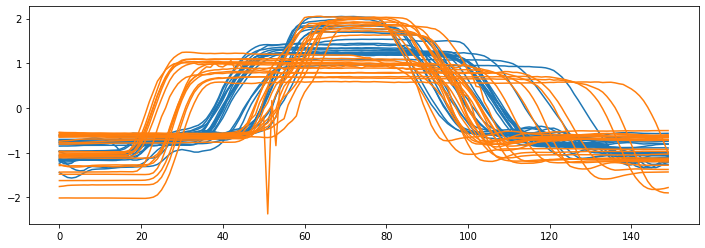

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(X[y==1].T, '#1F77B4')
plt.plot(X[y==2].T, '#FF7F0E')
plt.show()

### Finding shapelets

In [ ]:
clf = LearningShapelets(random_state=42, tol=0.01)
clf.fit(X, y)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


LearningShapelets(C=1000, alpha=-100, class_weight=None, fit_intercept=True,
                  intercept_scaling=1.0, learning_rate=1.0, max_iter=1000,
                  min_shapelet_length=0.1, multi_class='multinomial',
                  n_jobs=None, n_shapelets_per_size=0.2, penalty='l2',
                  random_state=42, shapelet_scale=3, tol=0.01, verbose=0)

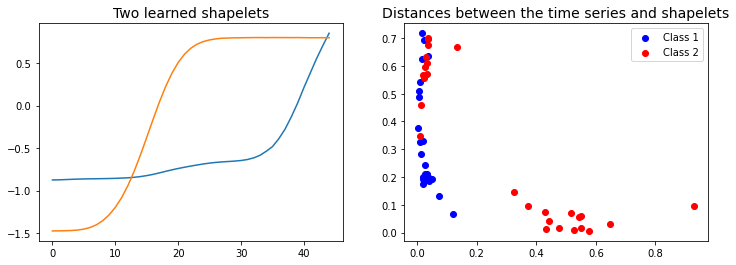

In [ ]:
shapelets = np.asarray([clf.shapelets_[0, -9], clf.shapelets_[0, -12]])

shapelet_size = shapelets.shape[1]
X_window = windowed_view(X, window_size=shapelet_size, window_step=1)
X_dist = np.mean((X_window[:, :, None] - shapelets[None, :]) ** 2, axis=3).min(axis=1)

# Plot shapelets
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(shapelets[0])
plt.plot(shapelets[1])
plt.title('Two learned shapelets', fontsize=14)

# Plot distances
plt.subplot(1, 2, 2)
for color, label in zip('br', (1, 2)):
    plt.scatter(X_dist[y == label, 0], X_dist[y == label, 1],
                c=color, label='Class {}'.format(label))
plt.title('Distances between the time series and shapelets', fontsize=14)
plt.legend()
plt.show()

### Examples of shapelets

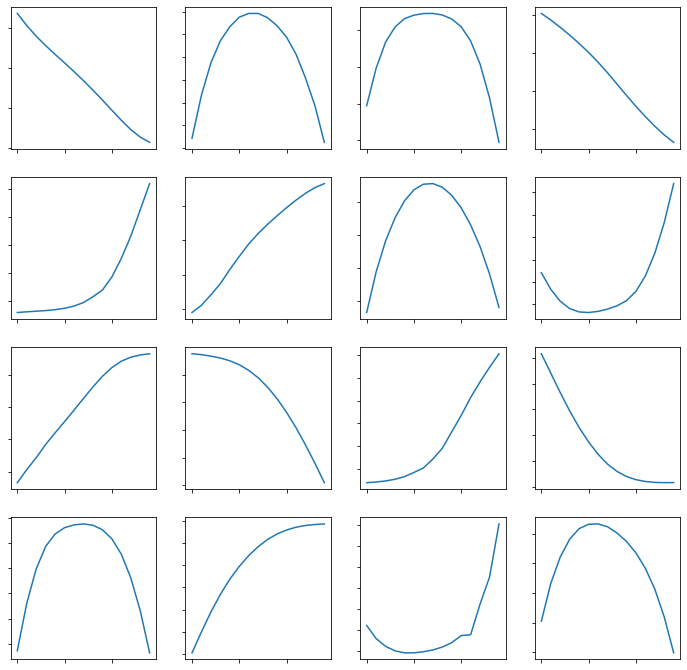

In [ ]:
plt.figure(figsize=(12,12))
for i in range(16):
    ax = plt.subplot(4, 4, 1 + i)
    ax.plot(clf.shapelets_[0, i])
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)


### Shapelets in time series

In [76]:
starting_points = np.argmin(np.mean((X_window[:, :, None] - shapelets[None, :])**2, axis=3), axis=1)

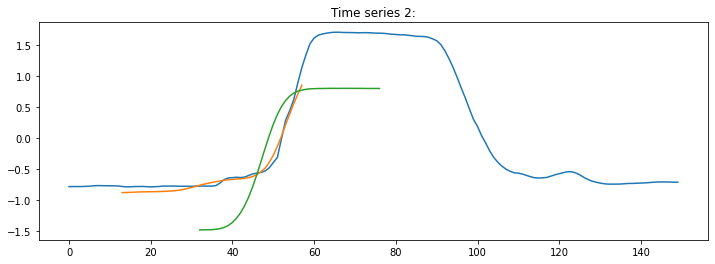

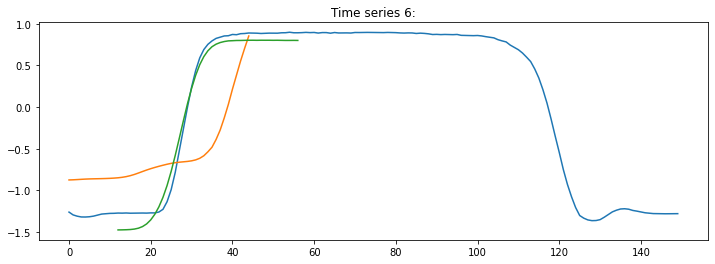

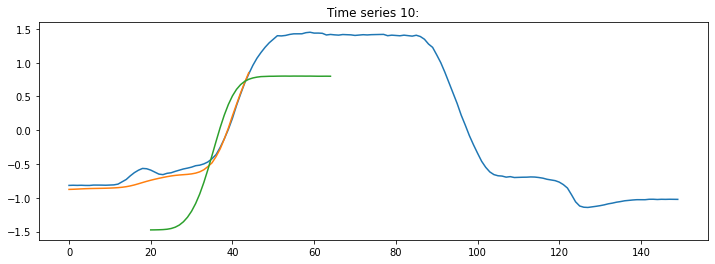

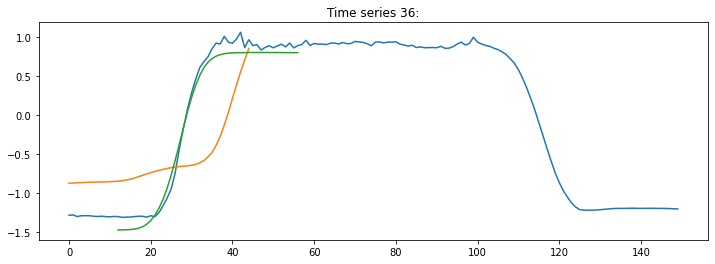

In [99]:
for ts_idx in (2, 6, 10, 36):
    plt.figure(figsize=(12,4))
    plt.title(f'Time series {ts_idx}:')
    plt.plot(X[ts_idx].T)
    for shapelet_idx in range(shapelets.shape[0]):
        start = starting_points[ts_idx][shapelet_idx]
        plt.plot(np.arange(start, start+shapelet_size),
                shapelets[shapelet_idx])

## Arrow head dataset

In [100]:
df = pd.read_csv('ArrowHead_TRAIN.txt', delimiter='  ', header=None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


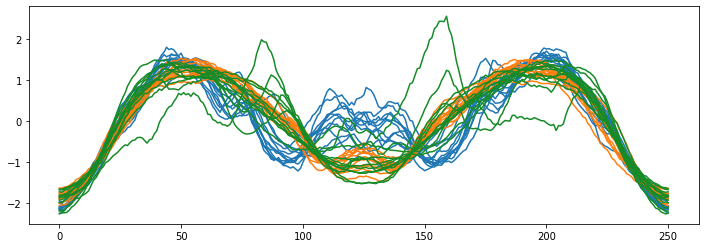

In [133]:
X = np.asarray(df.iloc[:, 1:])
y = np.asarray(df.iloc[:, 0])

plt.figure(figsize=(12,4))
plt.plot(X[y==0].T, '#1F77B4')
plt.plot(X[y==1].T, '#FF7F0E')
plt.plot(X[y==2].T, '#158B27')
plt.show()

### Finding shapelets

In [134]:
clf = LearningShapelets(random_state=42, tol=0.01)
clf.fit(X, y)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


LearningShapelets(C=1000, alpha=-100, class_weight=None, fit_intercept=True,
                  intercept_scaling=1.0, learning_rate=1.0, max_iter=1000,
                  min_shapelet_length=0.1, multi_class='multinomial',
                  n_jobs=None, n_shapelets_per_size=0.2, penalty='l2',
                  random_state=42, shapelet_scale=3, tol=0.01, verbose=0)

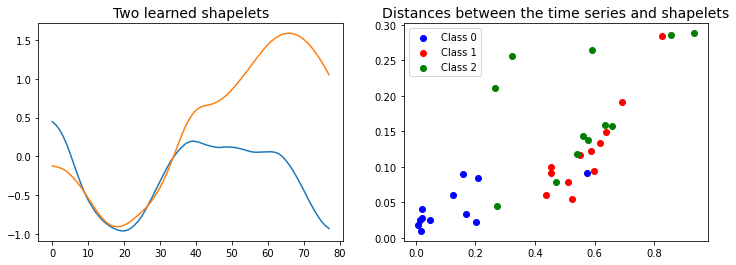

In [142]:
shapelets = np.asarray([clf.shapelets_[0, -9], clf.shapelets_[0, -6]])

shapelet_size = shapelets.shape[1]
X_window = windowed_view(X, window_size=shapelet_size, window_step=1)
X_dist = np.mean((X_window[:, :, None] - shapelets[None, :]) ** 2, axis=3).min(axis=1)

# Plot shapelets
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(shapelets[0])
plt.plot(shapelets[1])
plt.title('Two learned shapelets', fontsize=14)

# Plot distances
plt.subplot(1, 2, 2)
for color, label in zip('brg', (0, 1, 2)):
    plt.scatter(X_dist[y == label, 0], X_dist[y == label, 1],
                c=color, label='Class {}'.format(label))
plt.title('Distances between the time series and shapelets', fontsize=14)
plt.legend()
plt.show()

### Examples of shapelets

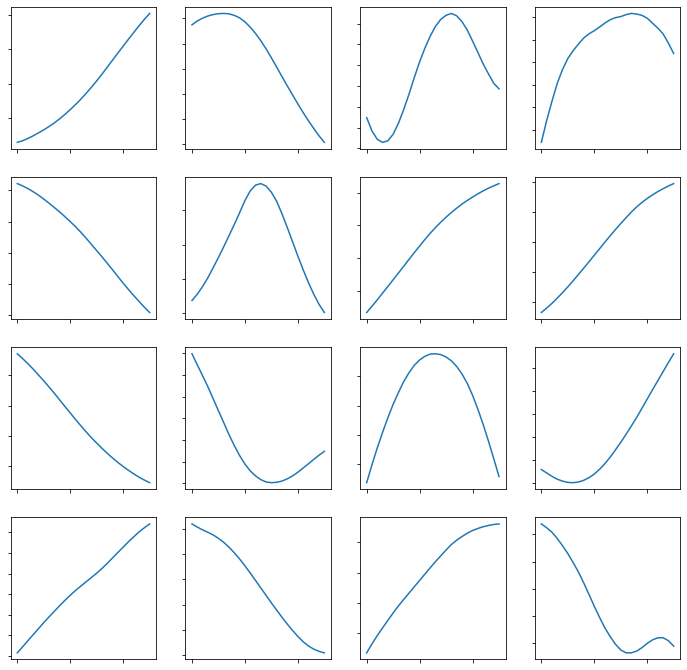

In [136]:
plt.figure(figsize=(12,12))
for i in range(16):
    ax = plt.subplot(4, 4, 1 + i)
    ax.plot(clf.shapelets_[0, i])
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)


### Shapelets in time series

In [150]:
X.shape

(36, 251)

In [151]:
X_window.shape

(36, 174, 78)

In [137]:
starting_points = np.argmin(np.mean((X_window[:, :, None] - shapelets[None, :])**2, axis=3), axis=1)

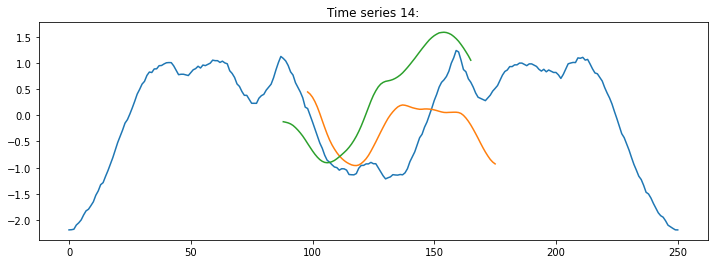

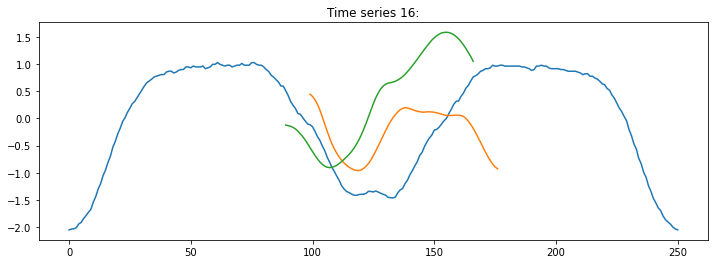

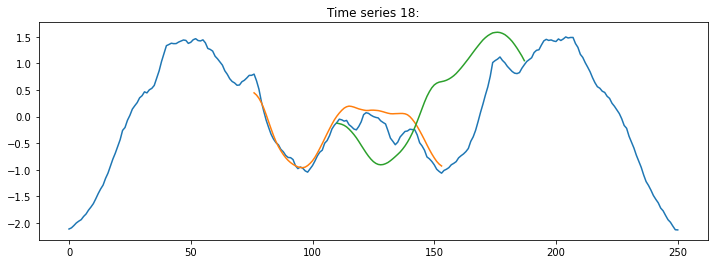

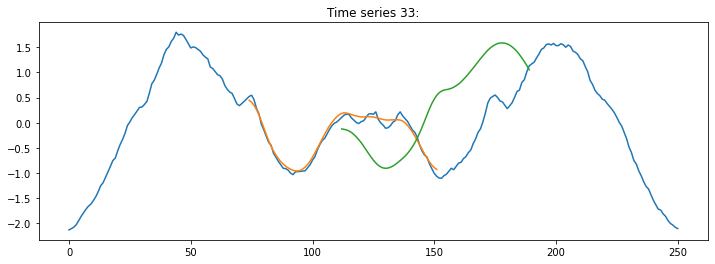

In [153]:
for ts_idx in (14, 16, 18, 33):
    plt.figure(figsize=(12,4))
    plt.title(f'Time series {ts_idx}:')
    plt.plot(X[ts_idx].T)
    for shapelet_idx in range(shapelets.shape[0]):
        start = starting_points[ts_idx][shapelet_idx]
        plt.plot(np.arange(start, start+shapelet_size),
                shapelets[shapelet_idx])